<a href="https://colab.research.google.com/github/ekvirika/WalmartRecruiting/blob/main/notebooks/model_experiment_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Install required packages
!pip install -q wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn mlflow pytorch_lightning pytorch_forecasting

# Set up Kaggle API
!pip install -q kaggle  dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.4 MB/s eta 0:00:00


In [5]:

# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json


In [6]:

# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 572MB/s]


In [7]:

!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip


unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


In [8]:
!pip install dagshub mlflow --quiet
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.4 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

import lightgbm as lgb
import mlflow
import mlflow.lightgbm
from mlflow.tracking import MlflowClient

warnings.filterwarnings('ignore')


In [10]:
import mlflow
from dagshub import dagshub_logger
import os

# Set tracking URI manually
mlflow.set_tracking_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

# Use your DagsHub credentials
os.environ["MLFLOW_TRACKING_USERNAME"] = "ekvirika"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "0adb1004ddd4221395353efea2d8ead625e26197"

# Optional: set registry if you're using model registry
mlflow.set_registry_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

🏃 View run LGBM_Data_Loading at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/986cd96414c94542a1ef485c459b4847
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0
🏃 View run LGBM_Cleaning at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/8f25551e447d4629b5c1da46196539c5
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0
🏃 View run LGBM_Feature_Engineering at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/493aeb3b716e47148ec797aff1843dee
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

✅ WMAE: 1950.99
🏃 View run LGBM_Training at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/ef42853470534b928a6c661256b0120e
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0
✅ Pipeline executed successfully!


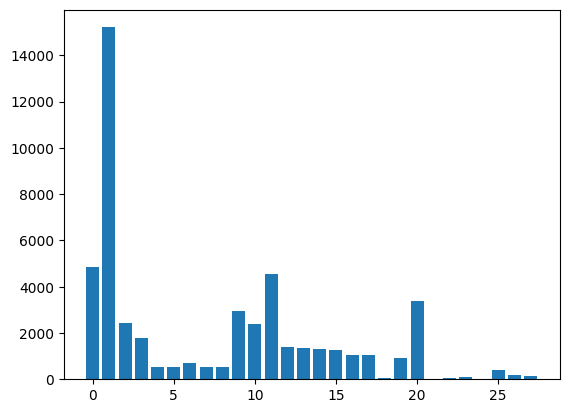

In [ ]:
# import mlflow.sklearn
# import mlflow.lightgbm
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import RandomizedSearchCV
# import matplotlib.pyplot as plt
# import joblib




# # ----------------------
# # Evaluation Metric (WMAE)
# # ----------------------
# def weighted_mae(y_true, y_pred, is_holiday):
#     weights = np.where(is_holiday, 5, 1)
#     return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# # ----------------------
# # Data Loader
# # ----------------------
# def load_data():
#     with mlflow.start_run(run_name="LGBM_Data_Loading", nested=True):
#         train_df = pd.read_csv('train.csv')
#         test_df = pd.read_csv('test.csv')
#         stores_df = pd.read_csv('stores.csv')
#         features_df = pd.read_csv('features.csv')

#         df = train_df.merge(features_df, on=['Store', 'Date'], how='inner') \
#                      .merge(stores_df, on='Store', how='inner')

#         mlflow.log_params({
#             "train_shape": train_df.shape,
#             "test_shape": test_df.shape,
#             "missing_values_train": train_df.isnull().sum().sum(),
#             "missing_values_test": test_df.isnull().sum().sum()
#         })

#         return df

# # ----------------------
# # Preprocessing
# # ----------------------
# def preprocess(df):
#     with mlflow.start_run(run_name="LGBM_Cleaning", nested=True):


#       df = df.copy()

#       # Fix column naming issues
#       df["IsHoliday"] = df.pop("IsHoliday_x") if "IsHoliday_x" in df else df["IsHoliday"]
#       df.drop(columns=["IsHoliday_y"], errors='ignore', inplace=True)

#       # Filter and sort
#       df = df[df["Weekly_Sales"] > 0]
#       df["Date"] = pd.to_datetime(df["Date"])
#       df = df.sort_values(by="Date")

#       # Remove outliers
#       q_low = df["Weekly_Sales"].quantile(0.01)
#       q_high = df["Weekly_Sales"].quantile(0.99)
#       df = df[(df["Weekly_Sales"] >= q_low) & (df["Weekly_Sales"] <= q_high)]

#       # Lag features
#       for lag in [1, 2, 4, 52]:
#           df[f"lag_{lag}"] = df.groupby("Store")["Weekly_Sales"].shift(lag)

#       # Rolling statistics
#       df["rolling_mean_4"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(window=4).mean()
#       df["rolling_std_4"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(window=4).std()

#       # Fill missing MarkDowns
#       markdown_cols = [col for col in df.columns if "MarkDown" in col]
#       df[markdown_cols] = df[markdown_cols].fillna(0)

#       # Date features
#       df["Year"] = df["Date"].dt.year
#       df["Month"] = df["Date"].dt.month
#       df["Week"] = df["Date"].dt.isocalendar().week
#       df["DayOfWeek"] = df["Date"].dt.dayofweek
#       df["IsMonthStart"] = df["Date"].dt.is_month_start.astype(int)
#       df["IsMonthEnd"] = df["Date"].dt.is_month_end.astype(int)
#       df["Quarter"] = df["Date"].dt.quarter
#       df.drop(columns=["Date"], inplace=True)

#       mlflow.log_params({"droppped_cols": "IsHoliday_x, IsHoliday_y, Date", "fill_markdown_NaNs": "0"})

#       # Drop rows with missing lag/rolling values
#       df = df.dropna()

#       return df

# # ----------------------
# # Dynamic Pipeline Builder
# # ----------------------
# def build_pipeline(X, model=None):
#     with mlflow.start_run(run_name="LGBM_Feature_Engineering", nested=True):

#       numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
#       categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

#       preprocessor = ColumnTransformer(transformers=[
#           ("num", SimpleImputer(strategy='mean'), numeric_cols),
#           ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
#       ])

#       if model is None:
#           model = LGBMRegressor(
#               n_estimators=100,
#               max_depth=6,
#               learning_rate=0.1,
#               random_state=42,
#               n_jobs=-1
#           )

#       pipeline = Pipeline([
#           ("preprocessor", preprocessor),
#           ("model", model)
#       ])

#       mlflow.log_params({"num_cols": numeric_cols, "cat_cols": categorical_cols,
#                         "simple_imputer": "mean", "cat_encoder": "one_hot", "pipeline": pipeline})

#       return pipeline

# # ----------------------
# # Runner
# # ----------------------
# def run():
#     # with mlflow.start_run(run_name="XGBoost_Training"):

#       df = load_data()
#       df = preprocess(df)

#       # Define features and target
#       X = df.drop(columns=["Weekly_Sales"])
#       y = df["Weekly_Sales"]

#       # Split
#       X_train, X_test, y_train, y_test = train_test_split(
#           X, y, test_size=0.2, random_state=42
#       )

#       # Store IsHoliday for WMAE
#       is_holiday_test = X_test["IsHoliday"].astype(bool).values if "IsHoliday" in X_test.columns else np.zeros_like(y_test)

#       # Train
#       pipeline = build_pipeline(X_train)

#       # Hyperparameter search space
#       param_dist = {
#           "model__n_estimators": [100, 200, 300, 500, 800, 1000],
#           "model__max_depth": [3, 6, 9, -1],  # -1 means no limit
#           "model__learning_rate": [0.01, 0.1],
#           "model__subsample": [0.6, 0.8, 1.0],  # still valid
#           "model__colsample_bytree": [0.6, 0.8, 1.0],  # also valid
#           "model__num_leaves": [31, 63, 127, 255, 511]
#       }


#       search = RandomizedSearchCV(
#           pipeline,
#           param_distributions=param_dist,
#           n_iter=20,
#           cv=3,
#           scoring="neg_mean_absolute_error",  # you could also define custom scorer using WMAE if needed
#           verbose=2,
#           n_jobs=-1,
#           random_state=42
#       )

#       search.fit(X_train, y_train)

#       best_model = search.best_estimator_
#       y_pred = best_model.predict(X_test)

#       # WMAE
#       wmae_score = weighted_mae(y_test.values, y_pred, is_holiday_test)
#       print(f"✅ WMAE: {wmae_score:.2f}")

#       mlflow.log_params(search.best_params_)
#       mlflow.log_metric("WMAE", wmae_score)
#       # mlflow.sklearn.log_model(best_model.named_steps["model"], artifact_path="lgbm_model")
#       joblib.dump(best_model.named_steps["model"], "lgbm_model.pkl")
#       mlflow.log_artifact("lgbm_model.pkl")

#       joblib.dump(best_model, "lgbm_pipeline.pkl")
#       mlflow.log_artifact("lgbm_pipeline.pkl")


#       # Save feature importance plot as artifact
#       fig, ax = plt.subplots()
#       lgb_model = best_model.named_steps["model"]
#       importances = lgb_model.feature_importances_
#       ax.bar(range(len(importances)), importances)
#       plt.savefig("feature_importance.png")
#       mlflow.log_artifact("feature_importance.png")


#       return best_model

# # ----------------------
# # Entry Point
# # ----------------------
# if __name__ == "__main__":
#     try:
#         with mlflow.start_run(run_name="LGBM_Training"):
#             model = run()
#         print("✅ Pipeline executed successfully!")
#     except Exception as e:
#         print(f"❌ Pipeline failed: {e}")


In [18]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

In [23]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import joblib

# ----------------------
# Evaluation Metric (WMAE)
# ----------------------
def weighted_mae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# ----------------------
# Custom Transformers
# ----------------------
class DataMerger(BaseEstimator, TransformerMixin):
    def __init__(self, features_df, stores_df):
        self.features_df = features_df
        self.stores_df = stores_df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.merge(self.features_df, on=['Store', 'Date'], how='inner')
        X = X.merge(self.stores_df, on='Store', how='inner')
        return X

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.q_low = None
        self.q_high = None

    def fit(self, X, y=None):
        if 'Weekly_Sales' in X.columns:
            self.q_low = X["Weekly_Sales"].quantile(0.01)
            self.q_high = X["Weekly_Sales"].quantile(0.99)
        return self

    def transform(self, X):
        X = X.copy()

        # Fix column naming issues
        X["IsHoliday"] = X.pop("IsHoliday_x") if "IsHoliday_x" in X else X["IsHoliday"]
        X.drop(columns=["IsHoliday_y"], errors='ignore', inplace=True)

        # Convert date and sort
        X["Date"] = pd.to_datetime(X["Date"])
        X = X.sort_values(by="Date")

        # Filter positive sales (only for training data)
        if 'Weekly_Sales' in X.columns:
            X = X[X["Weekly_Sales"] > 0]

            # Remove outliers using fitted quantiles
            if self.q_low is not None and self.q_high is not None:
                X = X[(X["Weekly_Sales"] >= self.q_low) & (X["Weekly_Sales"] <= self.q_high)]

        return X

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Lag features (only if Weekly_Sales exists)
        if 'Weekly_Sales' in X.columns:
            for lag in [1, 2, 4, 52]:
                X[f"lag_{lag}"] = X.groupby("Store")["Weekly_Sales"].shift(lag)

            # Rolling statistics
            X["rolling_mean_4"] = X.groupby("Store")["Weekly_Sales"].shift(1).rolling(window=4).mean()
            X["rolling_std_4"] = X.groupby("Store")["Weekly_Sales"].shift(1).rolling(window=4).std()

        # Fill missing MarkDowns
        markdown_cols = [col for col in X.columns if "MarkDown" in col]
        X[markdown_cols] = X[markdown_cols].fillna(0)

        # Date features
        X["Year"] = X["Date"].dt.year
        X["Month"] = X["Date"].dt.month
        X["Week"] = X["Date"].dt.isocalendar().week
        X["DayOfWeek"] = X["Date"].dt.dayofweek
        X["IsMonthStart"] = X["Date"].dt.is_month_start.astype(int)
        X["IsMonthEnd"] = X["Date"].dt.is_month_end.astype(int)
        X["Quarter"] = X["Date"].dt.quarter

        # Drop Date column
        X.drop(columns=["Date"], inplace=True)

        return X

class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fill_values = {}
        pass

    def fit(self, X, y=None):
        # Store mean values for numerical columns
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if X[col].isnull().any():
                self.fill_values[col] = X[col].mean()
        return self

    def transform(self, X):
        X = X.copy()

        # Fill numerical columns with stored means
        for col, fill_value in self.fill_values.items():
            if col in X.columns:
                X[col] = X[col].fillna(fill_value)

        # Drop rows with any remaining missing values (from lag features)
        X = X.dropna()

        return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_cols = []
        self.categorical_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        self.categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
        return self

    def transform(self, X):
        # This transformer just passes through the data but stores column info
        return X

    def get_feature_names_out(self):
        return self.numeric_cols, self.categorical_cols

In [25]:
# from sklearn.pipeline import Pipeline
# from lightgbm import LGBMRegressor

# full_pipeline = Pipeline([
#     ('merger', DataMerger(features_df, stores_df)),
#     ('cleaner', DataCleaner()),
#     ('feature_engineer', FeatureEngineer()),
#     ('missing_handler', MissingValueHandler()),
#     ('feature_selector', FeatureSelector()),
#     ('model', LGBMRegressor(
#         n_estimators=800,
#         max_depth=-1,
#         learning_rate=0.1,
#         random_state=42,
#         n_jobs=-1,
#         num_leaves=63
#     ))
# ])

# Define preprocessing after FeatureSelector
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", []),  # to be filled after fit
        ("cat", OneHotEncoder(handle_unknown="ignore"), [])
    ]
)

# Full pipeline with preprocessing + model
full_pipeline = Pipeline([
    ('merger', DataMerger(features_df, stores_df)),
    ('cleaner', DataCleaner()),
    ('feature_engineer', FeatureEngineer()),
    ('missing_handler', MissingValueHandler()),
    ('feature_selector', FeatureSelector()),  # No transform here
    ('preprocessor', preprocessor),          # You’ll configure this dynamically
    ('model', LGBMRegressor(
        n_estimators=800,
        max_depth=-1,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        num_leaves=63
    ))
])


In [27]:
# Run until feature selector
X_tmp = X_train.copy()
for name, step in full_pipeline.steps[:-3]:  # Up to feature_selector
    X_tmp = step.fit_transform(X_tmp)

# Get selected columns
numeric_cols = X_tmp.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_tmp.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

# Set correct columns for preprocessor
full_pipeline.named_steps['preprocessor'].transformers[0] = ("num", "passthrough", numeric_cols)
full_pipeline.named_steps['preprocessor'].transformers[1] = ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)


In [28]:
df = train_df.copy()
X = df.drop(columns=["Weekly_Sales"])
y = df["Weekly_Sales"]


# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

with mlflow.start_run(run_name="LGBM_Training"):

  full_pipeline.fit(X_train, y_train)

  y_pred = full_pipeline.predict(X_test)
  is_holiday = X_test["IsHoliday"].astype(bool).values  # Needed for WMAE

  wmae_score = weighted_mae(y_test.values, y_pred, is_holiday)
  mae_score = mean_absolute_error(y_test.values, y_pred)

  mlflow.log_metric("WMAE", wmae_score)
  mlflow.log_metric("MAE", mae_score)

  model = full_pipeline.named_steps["model"]
  mlflow.log_params({
      "n_estimators": model.n_estimators,
      "max_depth": model.max_depth,
      "learning_rate": model.learning_rate,
      "num_leaves": model.num_leaves
  })

  mlflow.sklearn.log_model(full_pipeline, "model_pipeline")


  print(f"WMAE: {wmae_score:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 23
[LightGBM] [Info] Start training from score 15979.221909


2025/07/31 08:34:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LGBM_Training at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/675548326c054866bdef13871866f3ef
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0


RestException: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}